In [1]:
%pip install transformers 
%pip install datasets 
%pip install scikit-learn
%pip install torch
%pip install datasets
%pip install accelerate
%pip install datasets 


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip in

### **0. Import Libraries**


In [11]:
import pandas as pd
import numpy as np
import time
import torch
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import requests


/Users/dimitriroulin/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### **1. Loading the Data and Model**
In this part, we load the dataset from a CSV file and preprocess it. We also convert the difficulty levels into numeric labels for classification.

In [17]:
import pandas as pd
train_data = pd.read_csv("./data/french_difficulty_train.csv")
test_data = pd.read_csv("./data/french_difficulty_test.csv")

print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")

display(train_data.head())
display(test_data.head())

Train size: 3840
Test size: 960


,sentence,difficulty
0,Est-ce que le professeur Omar est libre ?,A1
1,Elle a 21 ans,A1
2,Alors comment ça marche ?,A1
3,A bientôt !,A1
4,Le chaufffeur de bus est en retard.,A1


,sentence,difficulty
0,"Dani, est-ce que tu t'es inscrite à ton concou...",A1
1,Elle passe aussi à la boulagerie et elle achèt...,A1
2,J'ai un frère et une soeur.,A1
3,Vous rentrez à quelle heure ?,A1
4,Qu'en pensez-vous ?,A1


In [18]:
train_data_reduced = pd.DataFrame()

train_data_reduced["sentence"] = train_data["sentence"]
train_data_reduced["difficulty_label"] = train_data["difficulty_label"]

display(train_data_reduced.head())


test_data_reduced = pd.DataFrame()

test_data_reduced["sentence"] = test_data["sentence"]
test_data_reduced["difficulty_label"] = test_data["difficulty_label"]

display(test_data_reduced.head())

KeyError: 'difficulty_label'

In [15]:
test_data_reduced.to_csv(".//Mistral/test_data.csv", index=False)
train_data_reduced.to_csv("./Mistral/train_data.csv", index=False)

NameError: name 'test_data_reduced' is not defined

In [19]:
import json
import pandas as pd

# Fonction pour convertir un DataFrame en format JSONL
def convertir_en_jsonl(df, fichier_sortie="donnees_entrainement.jsonl"):
    with open(fichier_sortie, "w", encoding="utf-8") as f:
        for _, row in df.iterrows():
            entry = {
                "messages": [
                    {"role": "system", "content": "Vous êtes un professeur de langue et un expert dans la classification des phrases selon les niveaux de difficulté CEFR."},
                    {"role": "user", "content": f"Merci d'attribuer à cette phrase un niveau de difficulté de A1 à C2 : \"{row['sentence']}\""},
                    {"role": "assistant", "content": row["difficulty"]}
                ]
            }
            f.write(json.dumps(entry, ensure_ascii=False) + "\n")

# Conversion et sauvegarde des fichiers JSONL
convertir_en_jsonl(train_data, "donnees_entrainement.jsonl")
convertir_en_jsonl(test_data, "donnees_test.jsonl")

# Affichage des premières lignes du fichier JSONL pour vérification
with open("donnees_entrainement.jsonl", "r", encoding="utf-8") as f:
    for _ in range(5):
        print(f.readline().strip())


{"messages": [{"role": "system", "content": "Vous êtes un professeur de langue et un expert dans la classification des phrases selon les niveaux de difficulté CEFR."}, {"role": "user", "content": "Merci d'attribuer à cette phrase un niveau de difficulté de A1 à C2 : \"Est-ce que le professeur Omar est libre ?\""}, {"role": "assistant", "content": "A1"}]}
{"messages": [{"role": "system", "content": "Vous êtes un professeur de langue et un expert dans la classification des phrases selon les niveaux de difficulté CEFR."}, {"role": "user", "content": "Merci d'attribuer à cette phrase un niveau de difficulté de A1 à C2 : \"Elle a 21 ans\""}, {"role": "assistant", "content": "A1"}]}
{"messages": [{"role": "system", "content": "Vous êtes un professeur de langue et un expert dans la classification des phrases selon les niveaux de difficulté CEFR."}, {"role": "user", "content": "Merci d'attribuer à cette phrase un niveau de difficulté de A1 à C2 : \"Alors comment ça marche ?\""}, {"role": "assi

Setup Mistral API Connection

In [ ]:
# Mistral API Key
MISTRAL_API_KEY = ""

# Mistral API Endpoint
MISTRAL_API_URL = "https://api.mistral.ai/v1/chat/completions"

# Define Model Names
BASELINE_MODEL ="open-mistral-nemo"
#FINETUNED_MODEL = "ft:open-mistral-7b:52509ba7:20250519:16dabe28"  # Model à 0.45 accuracy
FINETUNED_MODEL = "ft:open-mistral-7b:52509ba7:20250519:f8677f19"




### **4. Define the Mistral 7B Query Function**

This function calls Mistral 7B to classify the sentence into CEFR levels.

In [31]:
# Define prompt template


# Define Prompt Template
PROMPT_TEMPLATE = """ 
You are a language assessor using the Common European Framework of Reference for Languages (CEFR).
Your task is to assign a language proficiency score to this text that is in german, using the CEFR levels from A1 (beginner) to C2 (advanced/native). 
Evaluate the given text and **ONLY** return one of the following levels: A1, A2, B1, B2, C1, or C2.
Do not provide any explanation or additional text. Just return the level.

Text: "{}"
"""

def query_mistral(sentence, model_name):
    """
    Queries the Mistral API to classify a sentence into CEFR levels.

    :param sentence: The German sentence to classify.
    :param model_name: The model to use ("mistral-small" or fine-tuned model ID).
    :return: The predicted CEFR level (A1 to C2) or None in case of an error.
    """
    prompt = PROMPT_TEMPLATE.format(sentence)

    headers = {
        "Authorization": f"Bearer {MISTRAL_API_KEY}",
        "Content-Type": "application/json",
    }

    data = {
        "model": model_name,
        "messages": [
            {"role": "system", "content": "You are a CEFR language proficiency classifier."},
            {"role": "user", "content": prompt},
        ],
        "temperature": 0.0,  # Ensures deterministic results
        "max_tokens": 2,  # We only need the CEFR level
    }

    try:
        response = requests.post(MISTRAL_API_URL, headers=headers, json=data)
        response.raise_for_status()  # Raise an error if the request fails
        result = response.json()
        
        return result["choices"][0]["message"]["content"].strip()
    
    except requests.exceptions.RequestException as e:
        print(f"API Error ({model_name}): {e}")
        return None





Test of the function that predict level.

In [6]:
# Print the row of true level A1
print(train_data_reduced[train_data_reduced["difficulty_label"] == "A1"].iloc[0])

NameError: name 'train_data_reduced' is not defined

In [32]:
import time

import requests

# Test s  entence
test_sentence = "Je m'appelle dimitri"


# Get predictions from both models
baseline_prediction = query_mistral(test_sentence, BASELINE_MODEL)
finetuned_prediction = query_mistral(test_sentence, FINETUNED_MODEL)

# Print the results
print(f"Sentence: {test_sentence}")
print(f"Baseline Model ({BASELINE_MODEL}) Prediction: {baseline_prediction}")
time.sleep(1)  # Sleep for 1 second to avoid rate limiting
print(f"Fine-Tuned Model Prediction: {finetuned_prediction}")

Sentence: Je m'appelle dimitri
Baseline Model (open-mistral-nemo) Prediction: A1
Fine-Tuned Model Prediction: A1


In [34]:
# get sample of test data
#sample_test_data = test_data.sample(30)
sample_test_data = test_data
display(sample_test_data)

,sentence,difficulty
0,"Dani, est-ce que tu t'es inscrite à ton concou...",A1
1,Elle passe aussi à la boulagerie et elle achèt...,A1
2,J'ai un frère et une soeur.,A1
3,Vous rentrez à quelle heure ?,A1
4,Qu'en pensez-vous ?,A1
...,...,...
955,"Je ne savais pas que, bien plus tristement que...",C2
956,"Comme Monsieur, un informaticien fondateur de ...",C2
957,"Alors qu'au cours du Paléolithique, la diffusi...",C2
958,"Ça vous débagoule des raisons, des accusations...",C2


In [35]:

# Create a DataFrame to store predictions
results = []
id = 0

# Iterate over the test dataset
for idx, row in sample_test_data.iterrows():
    sentence = row["sentence"]
    y_true = row["difficulty"]
    
    print(f"Processing sentence {id + 1}/{len(sample_test_data)}: {sentence}")

    finetuned_pred = query_mistral(sentence, FINETUNED_MODEL)
    time.sleep(2)  # Delay between API calls

    # Store results
    results.append({
        "sentence": sentence,
        "true_difficulty": y_true,
        "mistral_finetuned_prediction": finetuned_pred
    })

    id += 1

# Convert results to DataFrame and save
df_results = pd.DataFrame(results)

# Display the results
display(df_results)


Processing sentence 1/960: Dani, est-ce que tu t'es inscrite à ton concours administratif ?
Processing sentence 2/960: Elle passe aussi à la boulagerie et elle achète une baguette toute chaude et des croissants pour le petit-déjeuner
Processing sentence 3/960: J'ai un frère et une soeur.
Processing sentence 4/960: Vous rentrez à quelle heure ?
Processing sentence 5/960: Qu'en pensez-vous ?
Processing sentence 6/960: Je m'appelle Henri.
Processing sentence 7/960: Nous avons un cours de Français.
Processing sentence 8/960: Vous aimez ce film ?
Processing sentence 9/960: On fait réparer ses chaussures
Processing sentence 10/960: Je suis le professeur Duquesnes.
Processing sentence 11/960: Qu'est-ce qu'il a ton petit chat ?
Processing sentence 12/960: Il trouve qu'il fait trop chaud, alors il s'est ennuyé
Processing sentence 13/960: Il me reste des croissants.
Processing sentence 14/960: Elle ne travaille pas
Processing sentence 15/960: Le restaurant est sur votre gauche
Processing sentenc

,sentence,true_difficulty,mistral_finetuned_prediction
0,"Dani, est-ce que tu t'es inscrite à ton concou...",A1,B1
1,Elle passe aussi à la boulagerie et elle achèt...,A1,B1
2,J'ai un frère et une soeur.,A1,A1
3,Vous rentrez à quelle heure ?,A1,A2
4,Qu'en pensez-vous ?,A1,A2
...,...,...,...
955,"Je ne savais pas que, bien plus tristement que...",C2,C2
956,"Comme Monsieur, un informaticien fondateur de ...",C2,B2
957,"Alors qu'au cours du Paléolithique, la diffusi...",C2,C1
958,"Ça vous débagoule des raisons, des accusations...",C2,C1


In [36]:

#Print classification report
from sklearn.metrics import classification_report



# Extract the true and predicted labels
y_true = df_results["true_difficulty"]

y_finetuned_pred = df_results["mistral_finetuned_prediction"]


# Print the classification report for the fine-tuned model
print("Mistral-7B Classification Report:")
print(classification_report(y_true, y_finetuned_pred))


Mistral-7B Classification Report:
              precision    recall  f1-score   support

          A1       0.80      0.26      0.39       160
          A2       0.41      0.49      0.45       160
          B1       0.40      0.59      0.47       160
          B2       0.34      0.61      0.43       160
          C1       0.34      0.31      0.33       160
          C2       0.72      0.21      0.32       160

    accuracy                           0.41       960
   macro avg       0.50      0.41      0.40       960
weighted avg       0.50      0.41      0.40       960



In [37]:
# Save the predictions to a CSV file
df_results.to_csv("mistral_finetuned_predictions_50.csv", index=False)

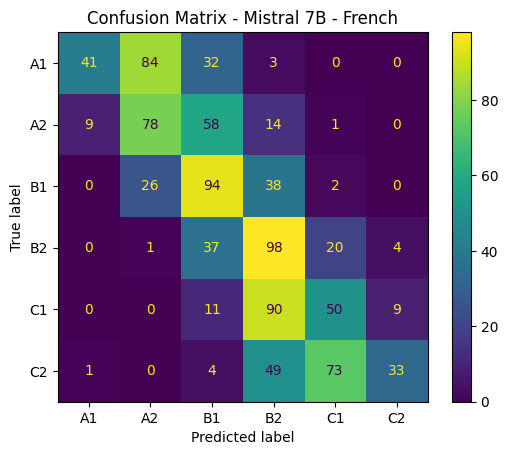

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# CEFR Mapping (A1=0, A2=1, ..., C2=5)
cefr_mapping = {"A1": 0, "A2": 1, "B1": 2, "B2": 3, "C1": 4, "C2": 5}
labels = ["A1", "A2", "B1", "B2", "C1", "C2"]

# Convert true labels to numerical format
y_true_numeric = df_results["true_difficulty"].map(cefr_mapping).tolist()

# Convert predictions to numeric format
y_pred_numeric = df_results["mistral_finetuned_prediction"].map(cefr_mapping).tolist()

# Filter out invalid predictions
valid_indices = [i for i in range(len(y_pred_numeric)) if y_pred_numeric[i] is not None]
y_true_filtered = [y_true_numeric[i] for i in valid_indices]
y_pred_filtered = [y_pred_numeric[i] for i in valid_indices]

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_filtered, y_pred_filtered, labels=range(6))

# Display confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=labels)
disp.plot(cmap="viridis")
plt.title(f"Confusion Matrix - Mistral 7B - French")
plt.show()


### Pairewise Mismmatch metric
The pairwise mismatch metric focuses on computing ordering violations in predictions relative to ground truth.
<img src="./Images/Pairewise-Matchinge-Explanation.png" width="800px">

In [39]:
from sklearn.preprocessing import LabelEncoder

def pairwise_mismatch(y_pred: pd.Series, y_real: pd.Series) -> float:
    """
    Compute the pairwise mismatch metric.
    
    :param y_pred: Pandas Series of predicted difficulty levels
    :param y_real: Pandas Series of true difficulty levels
    :return: Mean pairwise mismatch score
    """
    predictions = pd.DataFrame({"pred": y_pred, "real": y_real})

    # Sort alphabetically by real and predicted labels
    predictions = predictions.sort_values(by=["real", "pred"])

    # Convert categorical labels into numeric values while keeping order
    predictions["pred"] = predictions["pred"].astype("category")
    predictions["real"] = predictions["real"].astype("category")

    # Initialize LabelEncoder and encode labels
    label_encoder = LabelEncoder()
    unique_labels = pd.unique(predictions[["pred", "real"]].values.ravel("K"))
    label_encoder.fit(unique_labels)

    predictions["pred"] = label_encoder.transform(predictions["pred"])
    predictions["real"] = label_encoder.transform(predictions["real"])

    # Compute the pairwise mismatch
    mismatch = (
        predictions["pred"].expanding().apply(lambda s: (s.iloc[-1] - s < 0).sum())
        + predictions["pred"][::-1]
        .expanding()
        .apply(lambda s: (s.iloc[-1] - s > 0).sum())[::-1]
    )

    return mismatch.mean()

# Compute pairwise mismatch for Mistral-7B



mismatch_score = pairwise_mismatch(y_true_filtered, y_pred_filtered)
print(f"Pairwise Mismatch Score (Mistral-7B-finetuned): {mismatch_score:.4f}")


Pairwise Mismatch Score (Mistral-7B-finetuned): 47.9875
